In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from MUA_helper import (make_NP_array_from_linear_data, cleanAxes, placeAxesOnGrid,filter_detect,butter_bandpass,
                        butter_bandpass_filter,basic_peak_detector,get_prepare_PSTHs,plot_save,plot_save_single)

from scipy import stats
import pickle 
import pandas as pd
import scipy.io as sio
import os
import time
import glob


pom 10,17 // 377
vpl 9,16 // 384

In [12]:
## VPL tactile together with PWB
"""roi_folder = r"F:\SNA-029958\processed"
probe = 1

rois_lower =sio.loadmat(os.path.join(roi_folder,'borders_lower_{}.mat'.format(probe)))['borders_lower']
rois_upper =sio.loadmat(os.path.join(roi_folder,'borders_upper_{}.mat'.format(probe)))['borders_upper']
rois_names =sio.loadmat(os.path.join(roi_folder,'borders_names_{}.mat'.format(probe)))['borders_names']

borders_lower = rois_lower.flatten().astype(int) -rois_lower.flatten().astype(int)[-1]
borders_upper = rois_upper.flatten().astype(int) -rois_upper.flatten().astype(int)[-1]

names = []
for i in range(borders_lower.size):
    names.append(rois_names[i][0][0])


border = int(376-borders_lower[6]/-10)
border2 = int(376-borders_lower[13]/-10)
"""

save = True

structure='VPL'
exp_name = 'SNA_035184_probe1_002'
working_dir =r"Z:\Neuropixel\Thalamus\SNA-035184\2019-07-18_10-52-01"


exp_name_list = exp_name.split("_")

metadata_path = (glob.glob(working_dir+'/NationalInstruments/*sweepParameter'))
metadata_path_names = [os.path.basename(path) for path in metadata_path ]
stimdata_path = (glob.glob(working_dir+'/NationalInstruments/*stimData*.pkl'))
stimdata_path_names = [os.path.basename(path) for path in stimdata_path ]

if "001" in exp_name_list:
    exp_id = "001"
elif "002" in exp_name_list:
    exp_id = "002"
else:
    print('exp Id input does not match dir content')
    
if "probe1" in exp_name_list:
    probe = "probe1"
    p=0
elif "probe2" in exp_name_list:
    probe = "probe2"
    p=2
else:
    print('probe input does not match dir content')
print(stimdata_path_names)   
print(probe)
print(exp_id)
    
for i in range(len(metadata_path_names)):
    if exp_id in metadata_path_names[i]:
        metaData = metadata_path_names[i]
        
for i in range(len(stimdata_path_names)):
    if exp_id in stimdata_path_names[i] and probe in stimdata_path_names[i] :
        stim_name = stimdata_path_names[i]

stim_data_path =os.path.join(working_dir,'NationalInstruments',stim_name)
raw_data_path = os.path.join(working_dir,'experiment1\\recording1\\continuous\\Neuropix-PXI-100.{}\\continuous.dat'.format(p))


border = int(0)
border2 = int(387)

metaData_path =os.path.join(working_dir,'NationalInstruments',metaData)
border_regions = ['','','']

ch_bin = 4
binsize = 0.250
samplingrate = 30000
chs = 384
thresh = -5
meta_tmp = pd.read_pickle(metaData_path)

sweeplength = meta_tmp.Sweeplength[0]
pre = meta_tmp['Pre Stimulus Time'][0]
trials = meta_tmp.Repititions[0]

duration=meta_tmp['Stimulus Duration'][0] 
baselines = []
stimuli = []
data_corrected_all = np.zeros([int(chs/ch_bin),int(sweeplength/binsize-1),int(meta_tmp.sweepID.values.max()+1)])

if exp_id == "001":
    baselinestart = int(pre -4)
    baselineend = pre
    stimulusstart = pre
    stimulusend = int(pre + 4)

elif exp_id == "002":
    baselinestart = int(pre -2)
    baselineend = pre
    stimulusstart = pre
    stimulusend = int(pre + 2)


areas_VPL =np.array([[0,40],[40,60],[60,75],[int(95-20),95]])
areas = areas_VPL

colors = plt.cm.coolwarm(np.linspace(0,1,np.unique(meta_tmp.sweepID).shape[0]))

#selection_VPL = [0,9,19,30,35,52,63,70,80,91]
#selection = selection_VPL
selection = np.arange(1)

['002_stimData_probe1.pkl']
probe1
002


In [11]:
np.unique(meta_tmp.sweepID).shape[0]

7

In [3]:
data_corrected_list = []
baselines = []
stimuli = []


with open(stim_data_path, 'rb') as f:
    x = pickle.load(f)   
try:
    timestamps = x["Stimstart"].values
except:
    timestamps = x['Timestamps'].dropna().values[::2]
    
    
for i in range(len(timestamps))[:]:
    
    color = colors[i]
    folder = 'timestamps_{}'.format(i)
    folder_path  = working_dir + '/MUA-Analysis/' + exp_name + '/'+str(thresh) + '/timestamps_{}/'.format(i)
    stimulus = '{}_feedback'.format(i)

    files = os.listdir(folder_path)
    files = files[:]
    #with open(stim_data_path, 'rb') as f:
    #   x = pickle.load(f)

    #feedback = x["Feedback"][stimulus]

    all_trials = {}
    for ch in range(chs):
        all_trials[str(ch)]= np.array([])
    print('dict created....')
    for trial in range(len(files)):
        test0 = np.load(os.path.join(folder_path,files[trial]))
        for ch in range(test0.shape[0]):
            all_trials[str(ch)] = np.sort(np.hstack((all_trials[str(ch)],test0[ch])))

    print('dict filled....')


    binwindow = binsize*samplingrate
    data = np.zeros([chs,int(sweeplength/binsize)-1])   
    bins = np.arange(0,sweeplength*samplingrate,binwindow)
    data_df = pd.DataFrame([])

    for x in range(chs):

        values,edges = np.histogram(all_trials[str(x)],bins)
        data[x,:] = values/binsize/trials

    data_shape = np.reshape(data, (ch_bin,-1),order='F')
    data_db = np.mean(data_shape,axis =0)
    data_new = np.reshape(data_db,(int(chs/ch_bin),-1),order='F')
    
    
    for t in range(int(chs/ch_bin)):
        data_df[str(t)] = data_new[t,:]
    
    baseline_df = data_df.iloc[int(baselinestart/binsize):int(baselineend/binsize)]
    baseline_stats = baseline_df.describe().T
    baseline_stats['var'] = baseline_df.var()
    data_corrected = pd.DataFrame([])
    baselines.append(baseline_stats)
    

    stimulus_df = data_df.iloc[int(stimulusstart/binsize):int(stimulusend/binsize)]
    stimulus_stats = stimulus_df.describe().T
    stimuli.append(stimulus_stats)

    for ii in range(int(chs/ch_bin)):

        data_corrected[str(ii)] = (data_df[str(ii)] - baseline_stats['mean'].iloc[ii])#/baseline_stats['std'].iloc[ii]
        
    data_corrected_all[:,:,i] = data_corrected.values.T 
np.save(os.path.join(working_dir ,'MUA-Analysis' ,exp_name ,str(thresh),'base_corrected_data.npy'),data_corrected_all)
    


dict created....
dict filled....
dict created....
dict filled....
dict created....
dict filled....
dict created....
dict filled....
dict created....
dict filled....
dict created....
dict filled....
dict created....
dict filled....


0


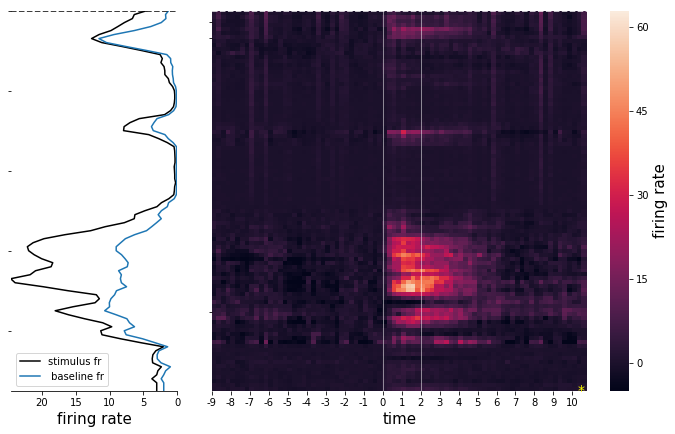

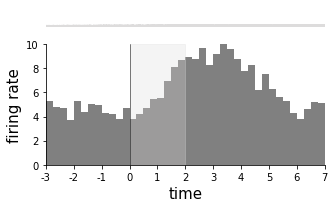

1


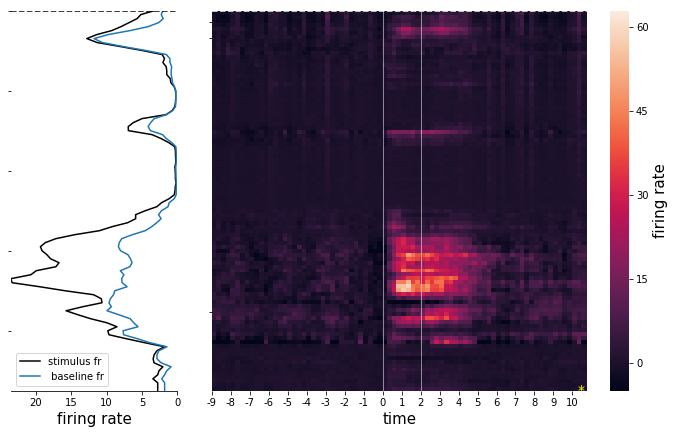

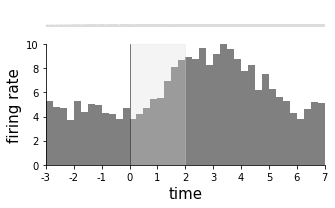

2


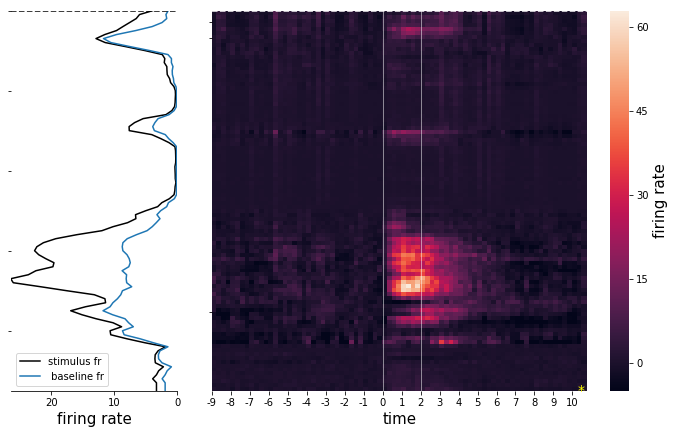

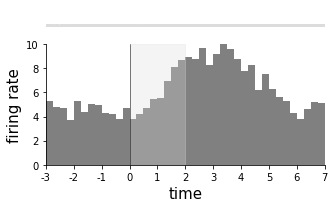

3


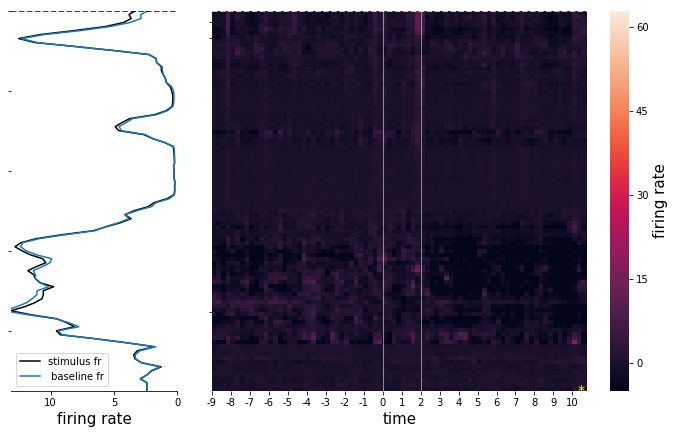

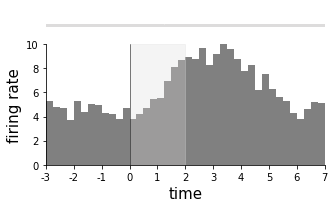

4


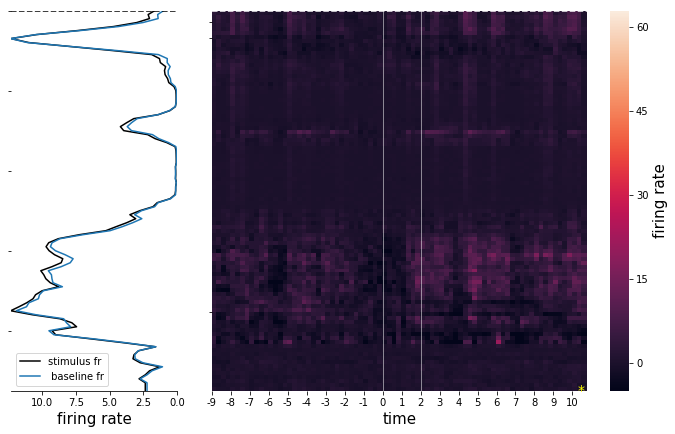

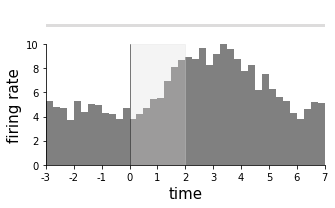

5


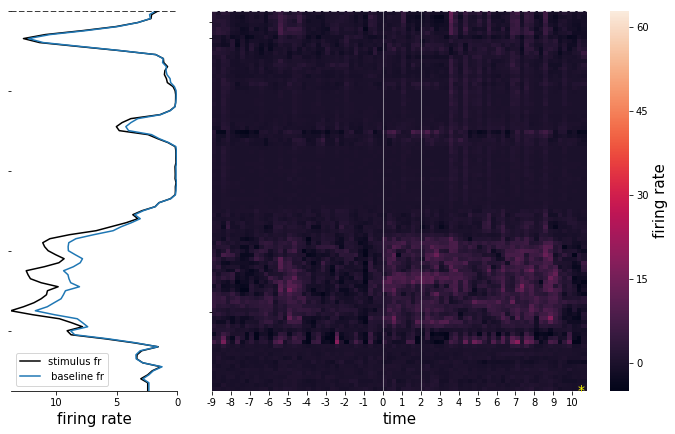

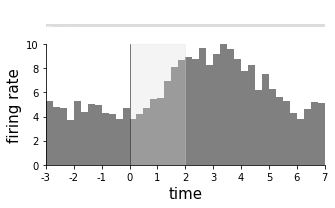

6


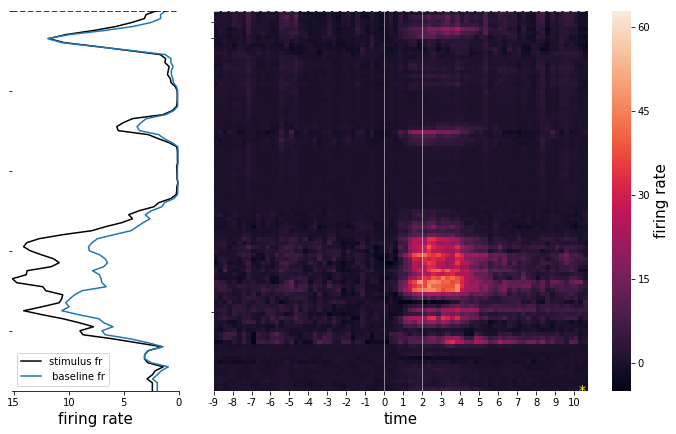

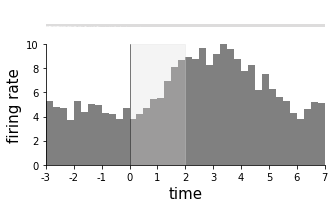

In [4]:
data_corrected_all = np.load(os.path.join(working_dir ,'MUA-Analysis' ,exp_name ,str(thresh),'base_corrected_data.npy'))

for i in range(data_corrected_all.shape[2]):
    folder = 'timestamps_{}'.format(i)
    print(i)
    data_corrected = data_corrected_all[:,:,i]

    path =os.path.join(working_dir ,'MUA-Analysis', exp_name,str(thresh),'plots','base_corrected',folder)    
    savepath= os.path.join(path,structure+'.png')
    if not os.path.isdir(path):
        os.makedirs(path)

    ticks = np.arange(0,int(data_corrected.shape[1]),1/binsize)
    time = np.arange(-pre,sweeplength-pre,binsize)



    fig = plt.figure(figsize=(12,10))

    ax1 = placeAxesOnGrid(fig,xspan=[0.3,1],yspan=[0.3,1])
    ax2 = placeAxesOnGrid(fig,xspan=[0,0.25],yspan=[0.3,1])
    cleanAxes(ax2,bottomLabels=True)


    sns.heatmap(data_corrected,vmin = -5,vmax = int(np.max(data_corrected_all)),ax=ax1,cbar_kws={'label': 'firing rate'})
    for s in selection:
        ax1.text(data_corrected.shape[1]-2,s-1,'*',color = 'yellow',fontsize=14)
    ax1.axhline(data_corrected.shape[0]-(border/4), ls='--', color = 'white', lw= 1.5)
    ax1.axhline(data_corrected.shape[0]-(border2/4), ls='--', color = 'white', lw= 1.5)
    #plt.ylim(0,int(chs/ch_bin))
    ax1.set_xticks(ticks)
    ax1.set_xticklabels(time[ticks.astype(int)].round().astype(int),rotation = 0)
    ax1.set_xlabel('time',fontsize = 15)
    ax1.axvline(pre/binsize,color = 'white',lw = 0.5)
    ax1.axvline((pre+duration)/binsize,color = 'white',lw = 0.5)
    ax1.set_yticks([data_corrected.shape[0]-3,data_corrected.shape[0]-(border/4)-7,20])
    ax1.set_yticklabels(border_regions,rotation=90,fontsize=10)
    ax1.set_ylim(0,data_corrected.shape[0])
    ax1.figure.axes[-1].yaxis.label.set_size(15)


    stim_rates = stimuli[i]['mean'].rolling(window=4).mean()/int(stimulusend-stimulusstart)
    base_rates = baselines[i]['mean'].rolling(window=4).mean()/int(baselineend-baselinestart)
    stim_rates[0:3]=stim_rates[4]
    base_rates[0:3]=base_rates[4]


    ax2.plot((stim_rates)[::-1],np.arange(0,data_corrected.shape[0]),color ='black',label='stimulus fr')
    ax2.plot(base_rates[::-1],np.arange(0,data_corrected.shape[0]),label= ' baseline fr')
    ax2.set_xlim(np.max(stim_rates),0)
    ax2.axhline((border/4), ls='--', color = 'black', lw= 1.5)
    ax2.axhline((border2/4), ls='--', color = 'black', lw= 1.5)
    ax2.set_ylim(data_corrected.shape[0]-1,0)
    ax2.set_xlabel('firing rate',fontsize = 15)
    ax2.spines['left'].set_visible(False)
    ax2.legend()
    if save:
        plt.savefig(str(savepath))
    plt.show()

    with open(stim_data_path, 'rb') as f:
        x = pickle.load(f)

    try:
        feedback = (x["Feedback_3"].dropna().values + x["Feedback_3"].dropna().values)/2
    except:
        feedback = (x['Feedback_3'].dropna().values[::2] + x['Feedback_4'].dropna().values[::2])/2
        
    
    feedback = feedback[i]
    feedbacktrace = (np.mean(np.mean(feedback[:],axis=1),axis=1))
    feedback_shifted = feedbacktrace#*0
    #feedback_shifted[:9000] = feedbacktrace[-9000:]
    #feedback_shifted[9000:] = feedbacktrace[:11000]
    
    feedback_shifted = (feedback_shifted - 0.2926) * 17.0898#selection = np.arange(data_df.shape[0])[::-1]

    for iii in range(len(selection)):

        #path =working_dir + '/MUA-Analysis/' + exp_name + '/'+str(thresh) +'/plots/'+folder
        savepath= os.path.join(path,'{0:03d}.png')
        if not os.path.isdir(path):
            os.makedirs(path)


        fig = plt.figure(figsize=(5,3))

        ax1 = placeAxesOnGrid(fig,yspan=[0.21,0.95])
        ax2 = placeAxesOnGrid(fig,yspan=[0,0.19])
        cleanAxes(ax2,total=True)

        ax1.bar(np.arange(data_df.shape[0]),(data_df.iloc[:,selection[::-1]][str(selection[iii])].values),
                align  = 'edge',width = 1, color = 'grey')
        #ax1.set_ylim(0,np.max(np.max(data_df.iloc[:,selection[::-1]]))/binsize/trials)
        ax1.set_ylim(0,int(np.max(np.max(data_df.iloc[:,selection]))))
        ax1.set_xticks(ticks)
        ax1.set_xticklabels(time[ticks.astype(int)].round().astype(int),rotation = 0)
        ax1.set_xlabel('time',fontsize = 15)
        ax1.set_ylabel('firing rate',fontsize = 15)
        ax1.axvline(pre/binsize,color = 'black',lw = 0.5)
        sns.despine(ax=ax1)
        ax1.axvspan(xmin=pre/binsize,xmax=(pre+2)/binsize,alpha=0.3,color=color)

        ax2.plot(feedback_shifted,color=color)
        ax2.set_ylim(22,42)
        ax2.set_xlim(int((pre-3)*1000),int((pre+7)*1000))
        ax1.set_xlim(int((pre-3)/binsize),int((pre+7)/binsize))
        
        if save:
            plt.savefig(savepath.format(selection[iii]))

        plt.show()

stimuli_all = pd.DataFrame([])
baselines_all = pd.DataFrame([])
        
for tt in range(len(baselines)):
    baselines[tt]['exp'] = tt
    stimuli[tt]['exp'] = tt
    
stimuli_all = pd.concat(stimuli)
baselines_all = pd.concat(baselines)

savepath1 = os.path.join(working_dir ,'MUA-Analysis' ,exp_name ,str(thresh),structure+'_stim.csv')
if save:
    stimuli_all.to_csv(savepath1)

savepath2 = os.path.join(working_dir ,'MUA-Analysis' ,exp_name ,str(thresh),structure+'_base.csv')
if save:
    baselines_all.to_csv(savepath2)

In [ ]:
int(np.max(data_corrected_all))

In [ ]:
savepath1 = r"Y:\Data\PB_DATA\Neruopixel_ProcessedData\JPO-001991\Post_CNO\2019-11-01_12-13-08\MUA-Analysis\JPO-001991_postCNO_probe1_001\-5\VPL_stim.csv"
savepath2 = r"Y:\Data\PB_DATA\Neruopixel_ProcessedData\JPO-001991\Post_CNO\2019-11-01_12-13-08\MUA-Analysis\JPO-001991_postCNO_probe1_001\-5\VPL_base.csv"


stimuli_all= pd.read_csv(savepath1,index_col=0)
baselines_all = pd.read_csv(savepath2,index_col=0)

In [5]:
#z-score data
stimuli_all['fr corrected'] = (stimuli_all['mean'] - baselines_all['mean']).values#/baselines_all['std']

thr = 1.5
stimuli_all_resp_tmp = stimuli_all[(abs(stimuli_all['fr corrected'])>thr)&(stimuli_all['exp']==0)]
stimuli_all_resp = stimuli_all.loc[stimuli_all_resp_tmp.index]
amps = pd.read_pickle(metaData_path)
try:
    amps = np.unique(amps['Stimulus Temp']).astype(float)
    
except:
    amps = np.unique(amps['Modalities'])
    

In [6]:
amps

array([ 23.,  26.,  29.,  32.,  35.,  38.,  41.])

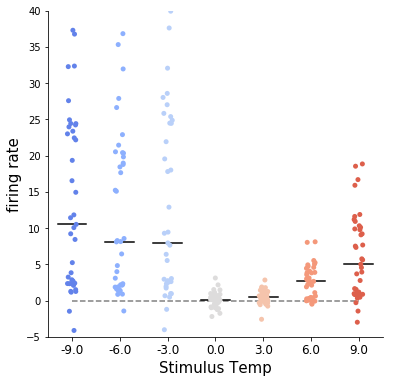

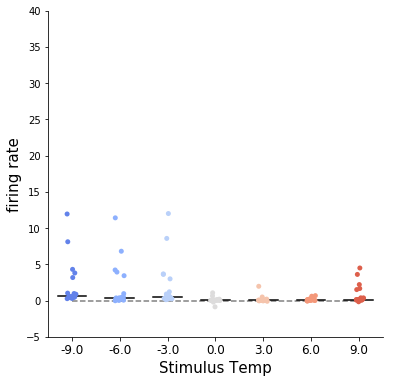

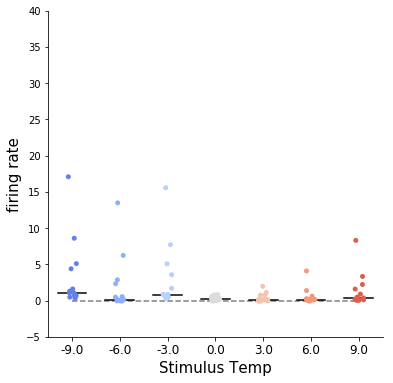

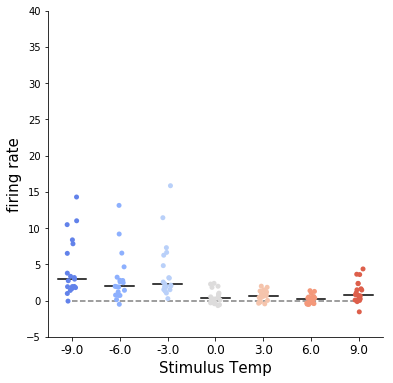

In [13]:
% matplotlib inline
for i in range(areas.shape[0]):
    fig = plt.figure(figsize=(6,6))
    ax = placeAxesOnGrid(fig)
    cleanAxes(ax,leftLabels=True)
    
    data_tmp = stimuli_all[(stimuli_all.index.values.astype(int) > int(areas[i][0]))&
                                             (stimuli_all.index.values.astype(int) < int(areas[i][-1]))]
    

    sns.stripplot(x='exp',y='fr corrected',data=data_tmp,palette = (sns.color_palette("coolwarm", n_colors=len(colors))),jitter = True,ax=ax)
    ax.plot(np.unique(data_tmp['exp']),np.zeros(np.unique(data_tmp['exp']).shape[0]),color='grey',ls='--')
    ax.set_ylim(-5,40)
    ax
    ax.set_xticklabels(amps-32,fontsize=12)
    #ax.set_yticks(np.arange(-5,10,1))
    #ax.set_yticklabels(np.arange(-5,10,1),fontsize=12)
    ax.set_xlabel('Stimulus Temp', fontsize = 15)
    ax.set_ylabel('firing rate', fontsize = 15)
    areas_stats = data_tmp.groupby('exp').median()
    
    window = 0.3
    
    for ii in range(np.unique(data_tmp['exp']).shape[0]):
        amp_tmp = np.unique(data_tmp['exp'])[ii]
        ax.plot([amp_tmp-window,amp_tmp+window],[areas_stats['fr corrected'][ii],areas_stats['fr corrected'][ii]],color='black')    
    
    savepath_tmp = os.path.join(os.path.dirname(path),structure+'_chs_{}_{}.png'.format(areas[i][0],areas[i][-1]))
    #savepath_tmp = os.path.join(working_dir,structure+'_chs_{}_{}.png'.format(areas[i][0],areas[i][-1]))
    plt.savefig(savepath_tmp)
    plt.show()

In [ ]:
% matplotlib inline

data_df_corr = data_df.corr(method = 'pearson')

sns.heatmap(data_df_corr,vmin=-1,vmax=1)
plt.show()

In [ ]:
% matplotlib inline 

start = 9
end = 13

window = np.arange(start*1000,end*1000)
feedback_all =x["Feedback_Force"]

for t in range(1):
    
    print('new amplitude')
    count = 0
    
    feedback = feedback_all[t][:,0,:]
    
    for i in range(25):
        smooth_feedback = Gaussian_smooth(feedback[:,i],250)
        plt.plot(smooth_feedback,lw = 0.8,alpha = 0.5)
        #plt.xlim(8000,12000)
        plt.ylim(0,10)
        peaks = basic_peak_detector(feedback[:,i], thresh=-1, orientation='positive', verbose=False)
        peaks = peaks[(peaks > window[0]) & (peaks < window [-1])]
        if peaks.size > 0:
            count +=1
            
            print('{} trials detected with paw movement during temp stim'.format(count))
        plt.show()
        

In [ ]:
baselinestart = 7
baselineend = 9

baseline_df = data_areas.iloc[int(baselinestart/binsize):int(baselineend/binsize)]
baseline_stats = baseline_df.describe().T
data_corrected = pd.DataFrame([])
baselines.append(baseline_stats)

for i in range(3):

    data_areas_corrected[str(i)] = (data_areas[str(i)] - baseline_stats['mean'].iloc[i])/baseline_stats['std'].iloc[i]

In [ ]:
for i in range(3):
    plt.plot(data_areas_corrected.iloc[:,i])
plt.xlim(35,45)
plt.show()

In [ ]:
test = pd.read_pickle(stim_data_path)

In [ ]:
test

In [ ]:
baselines_all